# MNIST Classification (softmax regression)

In this notebook, I implement softmax regression from scratch on the MNIST Dataset. I add in some extra features like:
* Mini-batch training
* L2 Regularization



In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from scipy.io import loadmat
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
mnist = loadmat('/content/gdrive/MyDrive/pyhon/mnist-original.mat')
# mnist = loadmat('mnist-original.mat')

X = mnist['data'].T # number of examples placed in row, features in column
Y = mnist['label'].T
Y = Y.astype('int')

n = X.shape[1]
m = Y.shape[0]

In [ ]:
print(X.shape, Y.shape)
print(f"The number of training examples: {m}, feature vector length: {n}")
print(Y)

img_size = np.sqrt(n).astype('int')
print(f"The image size is: {img_size} x {img_size}")

(70000, 784) (70000, 1)
The number of training examples: 70000, feature vector length: 784
[[0]
 [0]
 [0]
 ...
 [9]
 [9]
 [9]]
The image size is: 28 x 28


In [ ]:
print(mnist)
print(f"X: {X.shape}, y: {Y.shape}")

print(f"Examples: {m}, Feature count: {n}")




{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014', '__version__': '1.0', '__globals__': [], 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
      dtype=object), 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}
X: (70000, 784), y: (70000, 1)
Examples: 70000, Feature count: 784


In [ ]:
img_size = int(np.sqrt(X.shape[1]))
print(f"The size of the image is {img_size} x {img_size}")

The size of the image is 28 x 28


In [ ]:
# Converting Y into one hot encoded labels

def oneHot(Y):
    m = Y.shape[0]
    classes = np.max(Y) + 1 # find max value of Y, number of classes should be max + 1, assuming zero indexing
    Yhot = np.zeros((m, classes))
    for i in range(m):
        Yhot[i, Y[i,:]] = 1

    return Yhot


In [ ]:
Yhot = oneHot(Y)

print(Yhot.shape)

(70000, 10)


In [ ]:
def img_gen(X, Y):
    m = X.shape[0]
    n = X.shape[1]

    img_size = np.sqrt(n).astype('int')
    arb = np.random.randint(0, m)
    img = X[arb].reshape(img_size, img_size)

    Yhot = oneHot(Y)

    print(f"The image below is the {arb}th image in the dataset, labeled {Y[arb]}, with one hot encoding {Yhot[arb,:]}")
    plt.imshow(img)

The image below is the 11438th image in the dataset, labeled [1], with one hot encoding [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


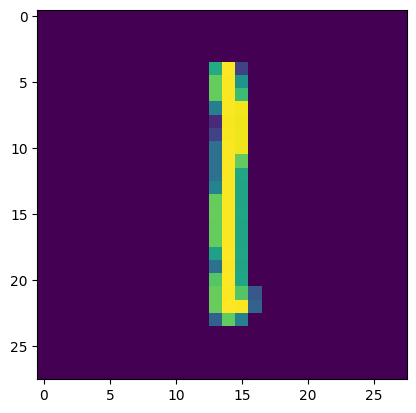

In [ ]:
img_gen(X, Y)

In [ ]:
# creating a normalization function

def normalize(data):
    # normalizing along rows because each column may have all zeros, i.e, black pixels in the edges of every image.
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    data_normalized = (data - mean)/std

    # norms = np.linalg.norm(data_normalized, axis = 1)
    # max_norm = norms.max()
    # data_normalized = data_normalized / max_norm
    return data_normalized

In [ ]:
X_norm = normalize(X)

print(np.linalg.norm(X_norm, axis = 1).max()) # sanity check

28.00000000000001


In [ ]:
# Split to train and test

X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.20, random_state=42)
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)
print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

print(np.sum((Y_train==0).astype(int)))
print(np.sum((Y_test==0).astype(int)))

The shape of the training set feature matrix is: (56000, 784)
The shape of the training label vector is: (56000, 1)
The shape of the test set feature matrix is: (14000, 784)
The shape of the test label vector is: (14000, 1)
5554
1349


The image below is the 28631th image in the dataset, labeled [1], with one hot encoding [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


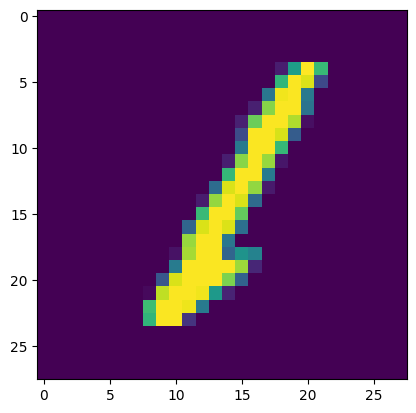

In [ ]:
img_gen(X_train,Y_train)

The image below is the 3809th image in the dataset, labeled [1], with one hot encoding [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


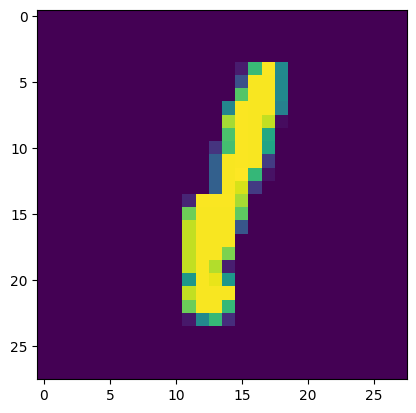

In [ ]:
img_gen(X_test,Y_test)


In [ ]:
# Concatenating X with a column of ones
def concatenator(X):
    m = X.shape[0]
    arb = np.hstack((np.ones([m,1]),X))
    print(f"The data now has a column of ones in front. It went from dimensions {X.shape} to {arb.shape}")
    return arb

In [ ]:
X_train_n = concatenator(X_train)
X_test_n = concatenator(X_test)

print(X_train_n.shape)
print(X_test_n.shape)


The data now has a column of ones in front. It went from dimensions (56000, 784) to (56000, 785)
The data now has a column of ones in front. It went from dimensions (14000, 784) to (14000, 785)
(56000, 785)
(14000, 785)


In [ ]:
a = np.random.randn(6,4)

b = np.sum(a, axis = 0, keepdims = True)

print(a.shape, b.shape)

c = a / b

print(c.shape)

print(a, b, c)

(6, 4) (1, 4)
(6, 4)
[[-1.09560242  1.37377977  0.91326885 -1.24439298]
 [ 0.28470539  1.00705691  0.13487349  0.91600892]
 [-0.33042534 -0.79868089  0.69034457 -0.83692774]
 [-0.25309046 -1.68331733  0.05513546  0.41550865]
 [ 0.58950379  0.02821826  2.26508184 -1.1974816 ]
 [ 0.02688535 -1.29027041  0.8496314  -0.85122167]] [[-0.77802369 -1.36321368  4.9083356  -2.79850642]] [[ 1.40818646 -1.00775087  0.18606487  0.44466326]
 [-0.36593409 -0.73873738  0.02747846 -0.32732064]
 [ 0.4246983   0.58588092  0.14064738  0.29906229]
 [ 0.32529918  1.23481546  0.01123303 -0.14847515]
 [-0.75769388 -0.02069981  0.46147656  0.42790025]
 [-0.03455595  0.94649168  0.1730997   0.30416999]]


In [ ]:
# Gradient initializer
def initializer(n):
    theta = np.random.randn(n[0],n[1]) * 0.01
    return theta

def softmax(z):
    arb = np.exp(z)
    return arb / np.sum(arb, axis = 1, keepdims = True)


# Implementation of hypothesis
def hypothesis(X, theta):
    z = np.matmul(X, theta)
    return softmax(z)

# Implementation of cost function
def cost(X, y, theta, lam):
    m = X.shape[0]
    h = hypothesis(X, theta)
    J = -(np.sum(y*np.log(h)) / m + (lam / (2*m)) * np.sum(theta**2))
    J = J.item()
    return J

# Gradient Calculations
def grad(X, y, theta, lam):
    m = X.shape[0]
    n = X.shape[1]
    h = hypothesis(X, theta)
    dtheta = np.matmul(X.T, (h-y)) / m + (lam / m) * theta

    return dtheta

In [ ]:
# Create prediction function

def predict(X, theta):
    Yhat_prob = hypothesis(X, theta)
    Yhat = np.argmax(Yhat_prob, axis = 1, keepdims = True)
    return Yhat, Yhat_prob

# Create prediction function, this is for passing image without concatenating 1 to it. Made it just in case

def predictor(X, theta):
    Yhat_prob = sig(theta[0] + np.dot(X, theta[1:]))
    Yhat = np.round(Yhat_prob).astype(int)
    return Yhat, Yhat_prob

In [ ]:
# Creating the gradient descent optimizer function

def gradient_descent(X, Y, X_test, Y_test, theta, alpha, epoch, batch_size, lam):

    i=0
    m = X.shape[0]
    # batch size when given equal to -1, will do batch gradient descent instead of mini batch
    if batch_size == -1:
        batch_size = m

    blocks = np.ceil(m / batch_size).astype('int')

    cost_history=[]
    test_acc_history = []
    train_acc_history = []

    Yhot = oneHot(Y) # one hot encoding the training labels

    J = cost(X, Yhot, theta, lam)

    cost_history.append(J)

    Yhat, _ = predict(X, theta)
    train_accuracy = accuracy_score(Y, Yhat)
    train_acc_history.append(train_accuracy)

    Yhat, _ = predict(X_test, theta)
    test_accuracy = accuracy_score(Y_test, Yhat)
    test_acc_history.append(test_accuracy)

    for i in range(epoch):
        if i % 10 == 0:
            print(f"iteration number {i} / {epoch}, Cost: {J}, Train Acc: {train_accuracy * 100}, Test Acc: {test_accuracy * 100}")
        for k in range(blocks):
            # print(f"Block count: {k*batch_size} / {m}")

            if (k+1) == blocks:
                X_curr = X[(k*batch_size):,:]
                Y_curr = Yhot[(k*batch_size):,:]
            else:
                X_curr = X[(k*batch_size):((k+1)*batch_size),:]
                Y_curr = Yhot[(k*batch_size):((k+1)*batch_size),:]

            J = cost(X_curr, Y_curr, theta, lam)
            dtheta = grad(X_curr, Y_curr, theta, lam)
            theta = theta - alpha * dtheta

            cost_history.append(J)

            Yhat, _ = predict(X, theta)
            train_accuracy = accuracy_score(Y, Yhat)
            train_acc_history.append(train_accuracy)

            Yhat, _ = predict(X_test, theta)
            test_accuracy = accuracy_score(Y_test, Yhat)
            test_acc_history.append(test_accuracy)


    return cost_history, train_acc_history, test_acc_history, theta, i

In [ ]:
a = np.array([[1,2,3],[4,5,6]])
print(np.max(a))

6


In [ ]:
def LogRegModel(X_train, Y_train, X_test, Y_test, alpha, epoch, batch_size, lam):

    n = X_train.shape[1] # number of features
    c = np.max(Y_train)+1 # number of classes
    theta = initializer([n, c])
    cost_history, train_acc_history, test_acc_history, theta, i = gradient_descent(X_train, Y_train, X_test, Y_test, theta, alpha, epoch, batch_size, lam)
    Yhat_train, _ = predict(X_train, theta)
    Yhat, _ = predict(X_test, theta)

    train_acc = accuracy_score(Y_train, Yhat_train)
    test_acc = accuracy_score(Y_test, Yhat)
    conf_matrix = confusion_matrix(Y_test, Yhat, normalize = None)

    model = {'weights': theta,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'confusion_matrix': conf_matrix,
            'cost_history': cost_history,
             'train_history': train_acc_history,
             'test_history': test_acc_history}
    return model

iteration number 0 / 100, Cost: 2.3316140340064955, Train Acc: 10.841071428571428, Test Acc: 10.678571428571429
iteration number 10 / 100, Cost: 0.670491289448545, Train Acc: 79.29642857142856, Test Acc: 79.96428571428571
iteration number 20 / 100, Cost: 0.4701671562250981, Train Acc: 87.78214285714286, Test Acc: 88.28571428571429
iteration number 30 / 100, Cost: 0.42351300153703497, Train Acc: 88.71071428571429, Test Acc: 89.08571428571429
iteration number 40 / 100, Cost: 0.3984008883780099, Train Acc: 89.22857142857143, Test Acc: 89.52142857142857
iteration number 50 / 100, Cost: 0.381425825692837, Train Acc: 89.58035714285715, Test Acc: 89.85714285714286
iteration number 60 / 100, Cost: 0.3689544893706784, Train Acc: 89.875, Test Acc: 90.10714285714285
iteration number 70 / 100, Cost: 0.35928346442439396, Train Acc: 90.06964285714287, Test Acc: 90.32857142857142
iteration number 80 / 100, Cost: 0.3514940158426791, Train Acc: 90.24285714285715, Test Acc: 90.45
iteration number 90 / 1

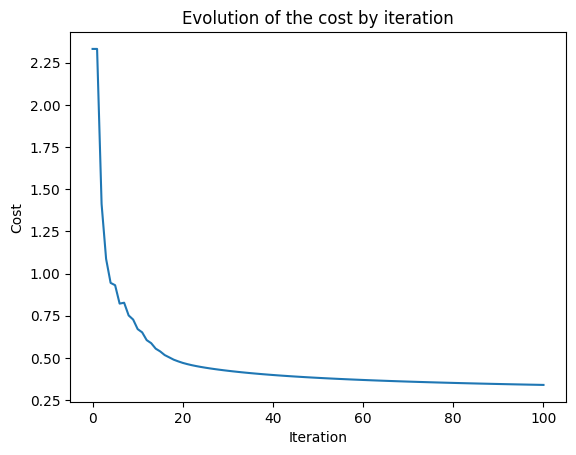

In [ ]:
# Testing the model function by training a classifier

l = 1
alpha = 0.1
epoch = 100
batch_size = -1
classes = np.max(Y_train)+1


model = LogRegModel(X_train_n, Y_train, X_test_n, Y_test, alpha, epoch, batch_size, l)
print('Training completed!')

print(f"The softmax classification model has the following properties:")
print(model['confusion_matrix'])
print(f"Train accuracy: {model['train_accuracy'] * 100} %, Test accuracy: {model['test_accuracy'] * 100} %")

plt.figure()
cost_values = model['cost_history']
plt.plot(list(range(len(cost_values))),cost_values)
plt.title('Evolution of the cost by iteration')
plt.xlabel('Iteration')
plt.ylabel('Cost');
plt.show()


# Viewing the cost evolution over time of the trained model



In [ ]:
# Calculatin the average accuracy of all the models

accuracy_list=[]
for i in range(tot_cls):
    accuracy_list.append(models['digit '+str(i)]['test_accuracy'])
ove_vs_all_accuracy=np.mean(accuracy_list)
print('The accuracy of the Onve-Vs-All model is:', ove_vs_all_accuracy * 100)


The accuracy of the Onve-Vs-All model is: 97.05428571428574


In [ ]:
def multiPredict(data, models):
    cls = len(models)
    example_count = data.shape[0]
    Yhat = np.zeros((example_count, cls))
    for i in range(cls):
        W = models['digit '+str(i)]['weights']
        _, arb = predict(data, W)

        Yhat[:,i] = arb.reshape(-1)

    Yhat_final = np.argmax(Yhat, axis = 1, keepdims = True)

    return Yhat_final

In [ ]:
Yhat_fin = multiPredict(X_test_n, models)

In [ ]:
print(confusion_matrix(Y_test, Yhat_fin, normalize = None))

[[1293    0    1    5    4    2   17    2   22    3]
 [   1 1530    8    9    1    7    3    2   19    1]
 [  18   21 1192   18   27    2   26   29   54   13]
 [   8    5   43 1262    1   36   12   15   34   18]
 [   3    4    5    2 1207    1   12    6   22   66]
 [  29   11   10   88   17  980   38    4   77   32]
 [  16    3   19    1    8   16 1334    1    9    0]
 [  12   13   28    7   21    1    1 1332    7   54]
 [  12   48   17   52    9   48   11    8 1156   30]
 [  16    6    9   38   64   12    0   61   17 1125]]


In [ ]:
print(np.sum(confusion_matrix(Y_test, Yhat_fin, normalize = None)))

14000


In [ ]:
print(accuracy_score(Y_test, Yhat_fin))

0.8865


In [ ]:
# Creating a one-vs-all function that uses all the trained models to predict the label of a random image

def one_vs_all(data, models_list):
    pred_matrix = np.zeros((data.shape[0],10))
    for i in range(len(models_list)):
        W = models['digit '+str(i)]['weights']
        Yhat, Yhat_prob = predict(data,W)
        pred_matrix[:,i] = Yhat_prob.T
    max_prob_vec = np.amax(pred_matrix, axis=1, keepdims=True)
    print(max_prob_vec)
    pred_matrix_max_prob = (pred_matrix == max_prob_vec).astype(int)
    labels=[]
    for j in range(pred_matrix_max_prob.shape[0]):
        idx = np.where(pred_matrix_max_prob[j,:]==1)
        labels.append(idx)
    labels = np.vstack(labels).flatten()
    return labels

In [ ]:
pred_label = one_vs_all(X_test_n, models)
conf_matrix = confusion_matrix(Y_test, pred_label)

[[0.89820473]
 [0.96322409]
 [0.46263231]
 ...
 [0.95619159]
 [0.82150392]
 [0.84740728]]


In [ ]:
print(conf_matrix)

[[1293    0    1    5    4    2   17    2   22    3]
 [   1 1530    8    9    1    7    3    2   19    1]
 [  18   21 1192   18   27    2   26   29   54   13]
 [   8    5   43 1262    1   36   12   15   34   18]
 [   3    4    5    2 1207    1   12    6   22   66]
 [  29   11   10   88   17  980   38    4   77   32]
 [  16    3   19    1    8   16 1334    1    9    0]
 [  12   13   28    7   21    1    1 1332    7   54]
 [  12   48   17   52    9   48   11    8 1156   30]
 [  16    6    9   38   64   12    0   61   17 1125]]


In [ ]:
# Doing the same thing but with a smaller version of MNIST

data = loadmat('/content/gdrive/MyDrive/pyhon/ex3data1.mat')

print(data)

X = data['X']

Y = data['y']

arb = np.where(Y == 10)[0]

Y[arb] = 0

print(X.shape, Y.shape)

n = X.shape[1]
m = Y.shape[0]

print(f"X: {X.shape}, y: {Y.shape}")

print(f"Examples: {m}, Feature count: {n}")




{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}
(5000, 400) (5000, 1)
X: (5000, 400), y: (5000, 1)
Examples: 5000, Feature count: 400


In [ ]:
img_size = int(np.sqrt(X.shape[1]))
print(f"The size of the image is {img_size} x {img_size}")

The size of the image is 20 x 20


In [ ]:
# Visualize a random MNIST image

def mnist_random(m):
    idx = np.random.randint(m)
    exp = np.reshape(X[idx], (img_size,img_size)).T
    print(f"The number in the image below is: {Y[idx]}")
    plt.imshow(exp)

The number in the image below is: [5]


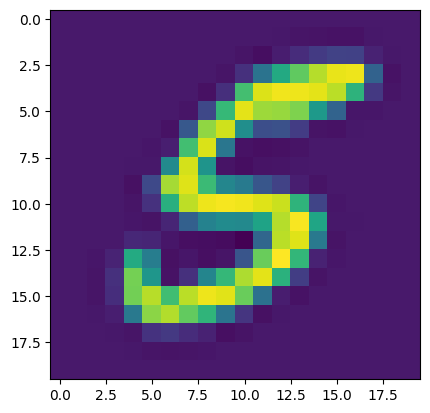

In [ ]:
mnist_random(m)

In [ ]:
X_norm = normalize(X)


In [ ]:
def visualize(X, Y, k):
    img = np.reshape(X[k,:],(img_size, img_size)).T
    print(f"The digit shown below is labeled {Y[k]} with index number {k}:")
    plt.imshow(img)

The digit shown below is labeled [2] with index number 1478:


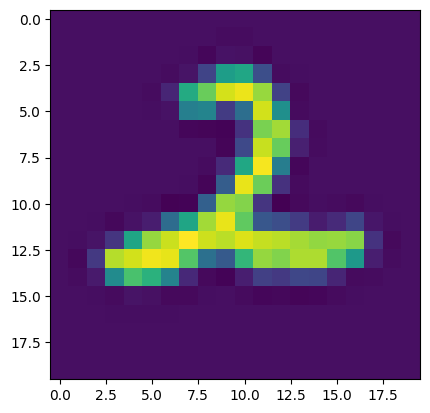

In [ ]:
idx = np.random.randint(m)
visualize(X,Y,idx)

In [ ]:
# Split to train and test

X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2, random_state=42)
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)
print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

print(np.sum((Y_train==0).astype(int)))
print(np.sum((Y_test==0).astype(int)))

The shape of the training set feature matrix is: (4000, 400)
The shape of the training label vector is: (4000, 1)
The shape of the test set feature matrix is: (1000, 400)
The shape of the test label vector is: (1000, 1)
389
111


In [ ]:
tot_cls = (np.max(Y) + 1).astype('int') # Number of classes, adding one to inclue zero

print(tot_cls.dtype, tot_cls)

int64 10


In [ ]:
Ymul_test = np.zeros((Y_test.shape[0], tot_cls))
Ymul_train = np.zeros((Y_train.shape[0], tot_cls))


for i in range(tot_cls):
    Ymul_test[:,i] = (Y_test == i).astype('int').reshape(-1)
    Ymul_train[:,i] = (Y_train == i).astype('int').reshape(-1)

print(Ymul_test.shape, Ymul_test[0:10,:])

(1000, 10) [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


The digit shown below is labeled [5] with index number 2146:
The Ymul vector for this specific example is: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


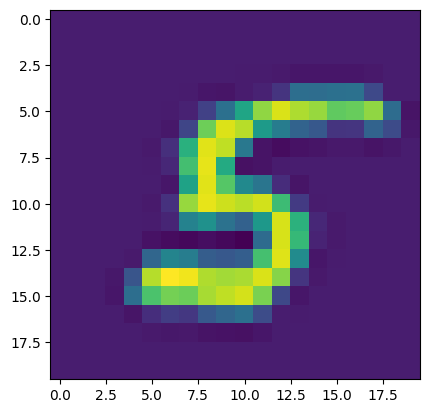

In [ ]:
idx = np.random.randint(X_train.shape[0])
visualize(X_train,Y_train,idx)

print(f"The Ymul vector for this specific example is: {Ymul_train[idx,:]}")

In [ ]:
X_train_n = concatenator(X_train)
X_test_n = concatenator(X_test)

print(X_train_n.shape)
print(X_test_n.shape)

The data now has a column of ones in front. It went from dimensions (4000, 400) to (4000, 401)
The data now has a column of ones in front. It went from dimensions (1000, 400) to (1000, 401)
(4000, 401)
(1000, 401)


iteration number 0 / 500, Cost: 0.6931471805599465, Train Acc: 90.275, Test Acc: 88.9
iteration number 10 / 500, Cost: 0.06986913717300626, Train Acc: 97.89999999999999, Test Acc: 98.1
iteration number 20 / 500, Cost: 0.05610256145203794, Train Acc: 98.5, Test Acc: 98.5
iteration number 30 / 500, Cost: 0.04963938312254948, Train Acc: 98.7, Test Acc: 98.9
iteration number 40 / 500, Cost: 0.045549493115942453, Train Acc: 98.825, Test Acc: 99.0
iteration number 50 / 500, Cost: 0.042617387135814096, Train Acc: 98.925, Test Acc: 98.9
iteration number 60 / 500, Cost: 0.040365384766212105, Train Acc: 98.9, Test Acc: 98.8
iteration number 70 / 500, Cost: 0.0385571180974185, Train Acc: 98.95, Test Acc: 98.8
iteration number 80 / 500, Cost: 0.037059107574923374, Train Acc: 98.97500000000001, Test Acc: 98.8
iteration number 90 / 500, Cost: 0.035788973114836795, Train Acc: 99.02499999999999, Test Acc: 98.8
iteration number 100 / 500, Cost: 0.03469248030200326, Train Acc: 99.02499999999999, Test Ac

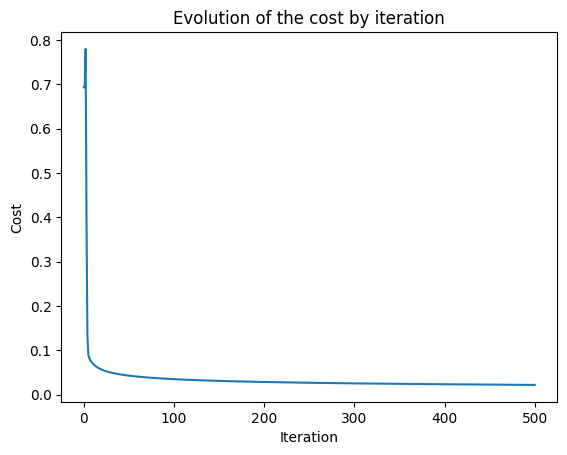

iteration number 0 / 500, Cost: 0.6931471805599465, Train Acc: 90.125, Test Acc: 89.5
iteration number 10 / 500, Cost: 0.045398811921194195, Train Acc: 98.825, Test Acc: 98.1
iteration number 20 / 500, Cost: 0.03936871511095525, Train Acc: 98.95, Test Acc: 98.4
iteration number 30 / 500, Cost: 0.03612973337216262, Train Acc: 99.125, Test Acc: 98.5
iteration number 40 / 500, Cost: 0.03401662442028926, Train Acc: 99.15, Test Acc: 98.7
iteration number 50 / 500, Cost: 0.03249352631508366, Train Acc: 99.175, Test Acc: 98.6
iteration number 60 / 500, Cost: 0.03132361305012635, Train Acc: 99.2, Test Acc: 98.6
iteration number 70 / 500, Cost: 0.0303846490219508, Train Acc: 99.225, Test Acc: 98.5
iteration number 80 / 500, Cost: 0.029606443723721558, Train Acc: 99.25, Test Acc: 98.5
iteration number 90 / 500, Cost: 0.028945443180950863, Train Acc: 99.25, Test Acc: 98.5
iteration number 100 / 500, Cost: 0.028372996894175606, Train Acc: 99.275, Test Acc: 98.5
iteration number 110 / 500, Cost: 0.

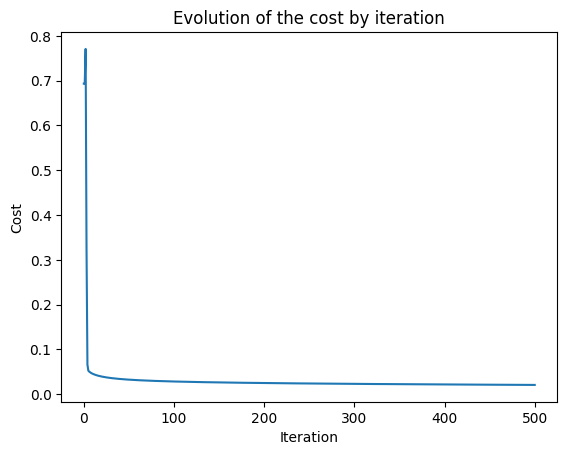

iteration number 0 / 500, Cost: 0.6931471805599466, Train Acc: 90.125, Test Acc: 89.5
iteration number 10 / 500, Cost: 0.12522404872783538, Train Acc: 95.975, Test Acc: 95.3
iteration number 20 / 500, Cost: 0.10605202370239049, Train Acc: 96.8, Test Acc: 95.6
iteration number 30 / 500, Cost: 0.09703468684837502, Train Acc: 97.02499999999999, Test Acc: 95.8
iteration number 40 / 500, Cost: 0.09149113940628084, Train Acc: 97.125, Test Acc: 95.7
iteration number 50 / 500, Cost: 0.08762904813216724, Train Acc: 97.3, Test Acc: 96.0
iteration number 60 / 500, Cost: 0.08472997189123176, Train Acc: 97.32499999999999, Test Acc: 96.1
iteration number 70 / 500, Cost: 0.08244233747616479, Train Acc: 97.425, Test Acc: 96.39999999999999
iteration number 80 / 500, Cost: 0.08057140987696267, Train Acc: 97.475, Test Acc: 96.39999999999999
iteration number 90 / 500, Cost: 0.07899961991568569, Train Acc: 97.6, Test Acc: 96.39999999999999
iteration number 100 / 500, Cost: 0.07765129307652772, Train Acc: 9

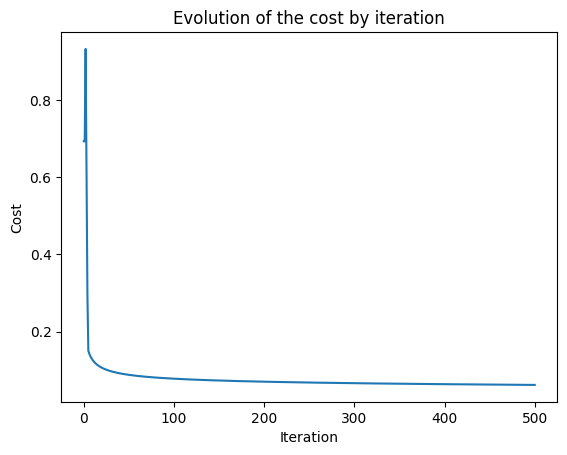

iteration number 0 / 500, Cost: 0.6931471805599465, Train Acc: 89.625, Test Acc: 91.5
iteration number 10 / 500, Cost: 0.1292940537676155, Train Acc: 95.875, Test Acc: 96.7
iteration number 20 / 500, Cost: 0.11284119836442716, Train Acc: 96.39999999999999, Test Acc: 97.0
iteration number 30 / 500, Cost: 0.10514876586481546, Train Acc: 96.525, Test Acc: 97.1
iteration number 40 / 500, Cost: 0.10031154613262633, Train Acc: 96.72500000000001, Test Acc: 97.0
iteration number 50 / 500, Cost: 0.09686990386918937, Train Acc: 96.875, Test Acc: 97.1
iteration number 60 / 500, Cost: 0.09424015575763199, Train Acc: 97.2, Test Acc: 97.1
iteration number 70 / 500, Cost: 0.09213486009236103, Train Acc: 97.2, Test Acc: 97.3
iteration number 80 / 500, Cost: 0.09039308876733793, Train Acc: 97.25, Test Acc: 97.2
iteration number 90 / 500, Cost: 0.08891641549007256, Train Acc: 97.275, Test Acc: 97.2
iteration number 100 / 500, Cost: 0.08764060678956405, Train Acc: 97.39999999999999, Test Acc: 97.2
iterat

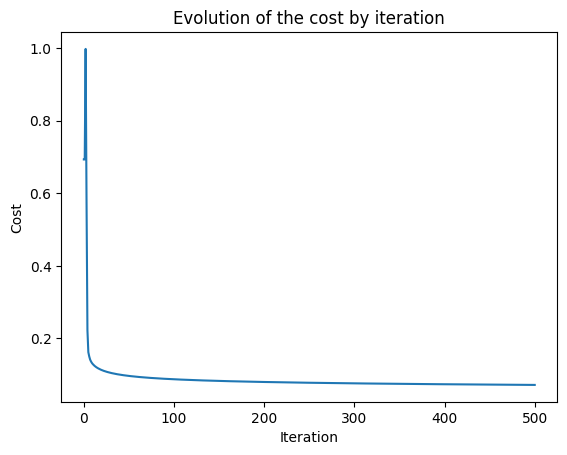

iteration number 0 / 500, Cost: 0.6931471805599466, Train Acc: 89.85, Test Acc: 90.60000000000001
iteration number 10 / 500, Cost: 0.10439641280910227, Train Acc: 97.02499999999999, Test Acc: 97.0
iteration number 20 / 500, Cost: 0.08780880473300674, Train Acc: 97.39999999999999, Test Acc: 97.3
iteration number 30 / 500, Cost: 0.07979477592337925, Train Acc: 97.75, Test Acc: 97.7
iteration number 40 / 500, Cost: 0.0747849586119923, Train Acc: 97.82499999999999, Test Acc: 97.89999999999999
iteration number 50 / 500, Cost: 0.07127311959544727, Train Acc: 97.95, Test Acc: 98.0
iteration number 60 / 500, Cost: 0.0686302658163475, Train Acc: 98.075, Test Acc: 97.89999999999999
iteration number 70 / 500, Cost: 0.06654173066155485, Train Acc: 98.075, Test Acc: 97.89999999999999
iteration number 80 / 500, Cost: 0.06483128526498558, Train Acc: 98.175, Test Acc: 97.89999999999999
iteration number 90 / 500, Cost: 0.06339202660847763, Train Acc: 98.125, Test Acc: 97.89999999999999
iteration number

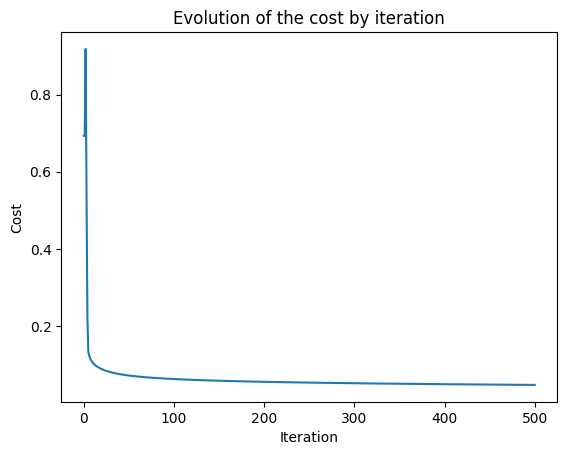

iteration number 0 / 500, Cost: 0.6931471805599465, Train Acc: 89.95, Test Acc: 90.2
iteration number 10 / 500, Cost: 0.15627687588461783, Train Acc: 94.05, Test Acc: 94.0
iteration number 20 / 500, Cost: 0.13145195296086326, Train Acc: 95.7, Test Acc: 95.39999999999999
iteration number 30 / 500, Cost: 0.1197003584962489, Train Acc: 96.0, Test Acc: 95.7
iteration number 40 / 500, Cost: 0.11241657660287445, Train Acc: 96.35000000000001, Test Acc: 95.8
iteration number 50 / 500, Cost: 0.10731619249097529, Train Acc: 96.525, Test Acc: 95.89999999999999
iteration number 60 / 500, Cost: 0.10347097582244658, Train Acc: 96.72500000000001, Test Acc: 95.7
iteration number 70 / 500, Cost: 0.1004248794831309, Train Acc: 96.89999999999999, Test Acc: 96.0
iteration number 80 / 500, Cost: 0.09792484299910882, Train Acc: 96.975, Test Acc: 96.2
iteration number 90 / 500, Cost: 0.09581786178650673, Train Acc: 97.02499999999999, Test Acc: 96.3
iteration number 100 / 500, Cost: 0.09400529994572324, Train

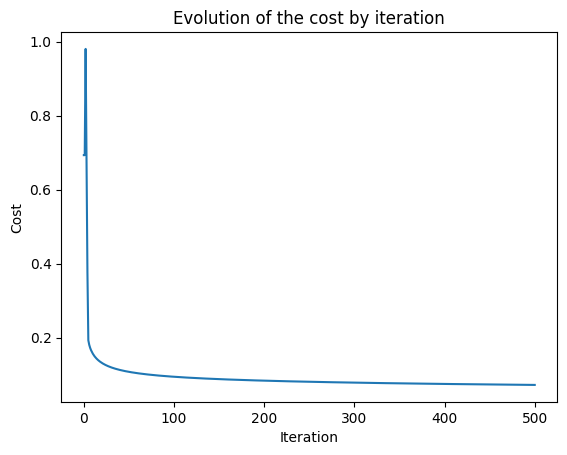

iteration number 0 / 500, Cost: 0.6931471805599466, Train Acc: 89.95, Test Acc: 90.2
iteration number 10 / 500, Cost: 0.07613966921512269, Train Acc: 97.875, Test Acc: 97.7
iteration number 20 / 500, Cost: 0.06247712066555299, Train Acc: 98.2, Test Acc: 98.0
iteration number 30 / 500, Cost: 0.05571774975904907, Train Acc: 98.375, Test Acc: 98.1
iteration number 40 / 500, Cost: 0.05154182158287314, Train Acc: 98.6, Test Acc: 97.8
iteration number 50 / 500, Cost: 0.04865020745253466, Train Acc: 98.65, Test Acc: 98.1
iteration number 60 / 500, Cost: 0.04649694612063299, Train Acc: 98.675, Test Acc: 98.2
iteration number 70 / 500, Cost: 0.044810142099149325, Train Acc: 98.8, Test Acc: 98.2
iteration number 80 / 500, Cost: 0.04343851944180288, Train Acc: 98.8, Test Acc: 98.2
iteration number 90 / 500, Cost: 0.042290946016934186, Train Acc: 98.825, Test Acc: 98.3
iteration number 100 / 500, Cost: 0.04130910376259737, Train Acc: 98.9, Test Acc: 98.4
iteration number 110 / 500, Cost: 0.0404538

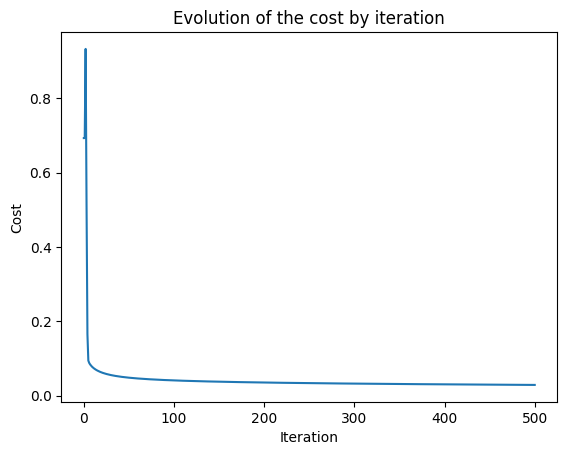

iteration number 0 / 500, Cost: 0.6931471805599466, Train Acc: 90.3, Test Acc: 88.8
iteration number 10 / 500, Cost: 0.07928509089852767, Train Acc: 97.45, Test Acc: 97.1
iteration number 20 / 500, Cost: 0.06923927298699184, Train Acc: 97.82499999999999, Test Acc: 97.3
iteration number 30 / 500, Cost: 0.06412341328234808, Train Acc: 97.975, Test Acc: 97.39999999999999
iteration number 40 / 500, Cost: 0.06079496333721326, Train Acc: 98.1, Test Acc: 97.39999999999999
iteration number 50 / 500, Cost: 0.05837394817088503, Train Acc: 98.2, Test Acc: 97.39999999999999
iteration number 60 / 500, Cost: 0.056492117410182514, Train Acc: 98.3, Test Acc: 97.6
iteration number 70 / 500, Cost: 0.054963295148291506, Train Acc: 98.32499999999999, Test Acc: 97.7
iteration number 80 / 500, Cost: 0.05368152776705106, Train Acc: 98.35000000000001, Test Acc: 97.7
iteration number 90 / 500, Cost: 0.05258129136256164, Train Acc: 98.375, Test Acc: 97.7
iteration number 100 / 500, Cost: 0.05161947468337295, Tr

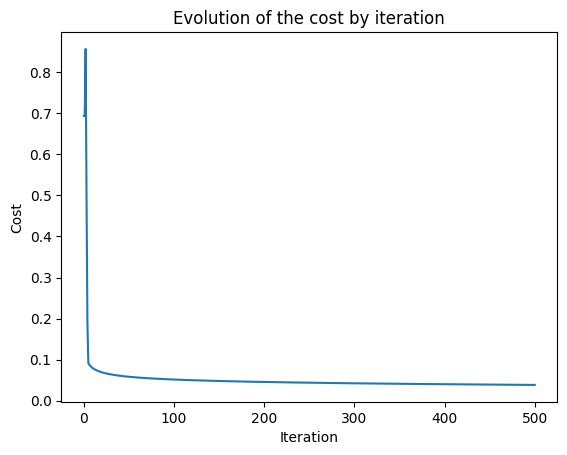

iteration number 0 / 500, Cost: 0.6931471805599465, Train Acc: 89.525, Test Acc: 91.9
iteration number 10 / 500, Cost: 0.2793396995694368, Train Acc: 93.10000000000001, Test Acc: 92.9
iteration number 20 / 500, Cost: 0.18713234666509873, Train Acc: 94.175, Test Acc: 95.0
iteration number 30 / 500, Cost: 0.16884563513362622, Train Acc: 94.35, Test Acc: 95.5
iteration number 40 / 500, Cost: 0.163136605182705, Train Acc: 94.45, Test Acc: 95.6
iteration number 50 / 500, Cost: 0.15919815871833748, Train Acc: 94.55, Test Acc: 95.7
iteration number 60 / 500, Cost: 0.15612264178614557, Train Acc: 94.675, Test Acc: 95.89999999999999
iteration number 70 / 500, Cost: 0.15359933123049535, Train Acc: 94.75, Test Acc: 95.7
iteration number 80 / 500, Cost: 0.1514586448349344, Train Acc: 94.825, Test Acc: 95.5
iteration number 90 / 500, Cost: 0.1495987588512289, Train Acc: 94.975, Test Acc: 95.6
iteration number 100 / 500, Cost: 0.14795405321684543, Train Acc: 95.19999999999999, Test Acc: 95.8
iterati

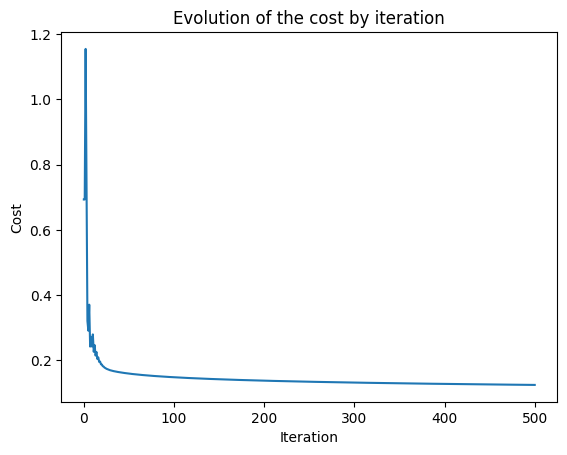

iteration number 0 / 500, Cost: 0.6931471805599465, Train Acc: 90.275, Test Acc: 88.9
iteration number 10 / 500, Cost: 0.20830247928332335, Train Acc: 93.325, Test Acc: 91.5
iteration number 20 / 500, Cost: 0.14923426447844987, Train Acc: 95.5, Test Acc: 93.89999999999999
iteration number 30 / 500, Cost: 0.1327114814982926, Train Acc: 95.85000000000001, Test Acc: 94.5
iteration number 40 / 500, Cost: 0.1261510862220537, Train Acc: 95.875, Test Acc: 94.89999999999999
iteration number 50 / 500, Cost: 0.12163176375766592, Train Acc: 96.175, Test Acc: 94.89999999999999
iteration number 60 / 500, Cost: 0.11824802312844218, Train Acc: 96.35000000000001, Test Acc: 95.0
iteration number 70 / 500, Cost: 0.11558653863976098, Train Acc: 96.39999999999999, Test Acc: 94.89999999999999
iteration number 80 / 500, Cost: 0.11341599019119614, Train Acc: 96.42500000000001, Test Acc: 95.19999999999999
iteration number 90 / 500, Cost: 0.11159625291150285, Train Acc: 96.42500000000001, Test Acc: 95.3
iterat

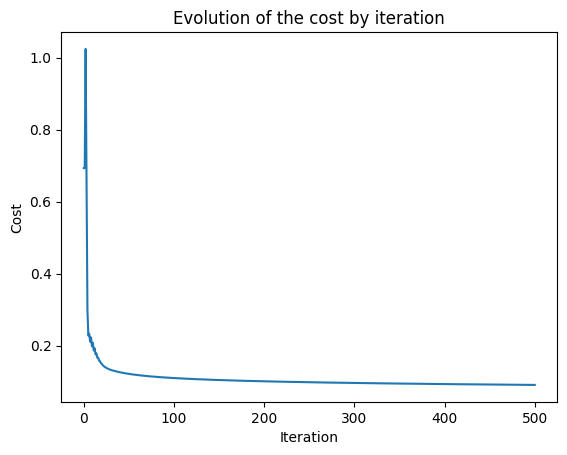

In [ ]:
# Testing the model function by training a classifier

l = 0
alpha = 0.2
epoch = 500
batch_size = -1

models = {}

for i in range(tot_cls):
    Ycurr_train = Ymul_train[:,i].reshape(-1,1)
    Ycurr_test = Ymul_test[:,i].reshape(-1,1)
    model = LogRegModel(X_train_n, Ycurr_train, X_test_n, Ycurr_test, alpha, epoch, batch_size, l)
    print('Training completed!')

    print(f"The model for classifying digit {i} has the following properties:")
    print(model['confusion_matrix'])
    print(f"Train accuracy: {model['train_accuracy'] * 100} %, Test accuracy: {model['test_accuracy'] * 100} %")

    models['digit ' + str(i)] = model

    plt.figure()
    cost_values = model['cost_history']
    plt.plot(list(range(len(cost_values))),cost_values)
    plt.title('Evolution of the cost by iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Cost');
    plt.show()


# Viewing the cost evolution over time of the trained model

In [ ]:
# Calculatin the average accuracy of all the models

accuracy_list=[]
for i in range(tot_cls):
    accuracy_list.append(models['digit '+str(i)]['test_accuracy'])
ove_vs_all_accuracy=np.mean(accuracy_list)
print('The accuracy of the Onve-Vs-All model is:', ove_vs_all_accuracy * 100)


The accuracy of the Onve-Vs-All model is: 97.45000000000002


In [ ]:
# Calculatin the average accuracy of all the models

accuracy_list=[]
for i in range(tot_cls):
    accuracy_list.append(models['digit '+str(i)]['train_accuracy'])
ove_vs_all_accuracy=np.mean(accuracy_list)
print('The accuracy of the Onve-Vs-All model is:', ove_vs_all_accuracy * 100)

The accuracy of the Onve-Vs-All model is: 98.23


In [ ]:
Yhat_fin = multiPredict(X_test_n, models)
test = accuracy_score(Y_test, Yhat_fin)

Yhat_fin_train = multiPredict(X_train_n, models)
train = accuracy_score(Y_train, Yhat_fin_train)

conf_mat_train = confusion_matrix(Y_train, Yhat_fin_train, normalize = None)
conf_mat = confusion_matrix(Y_test, Yhat_fin, normalize = None)

print(f"Train accuracy: {train * 100}, Test accuracy: {test * 100}")

Train accuracy: 93.625, Test accuracy: 90.0


In [ ]:

print(conf_mat)

print(conf_mat_train)

[[110   0   0   0   0   0   0   0   0   1]
 [  0 101   1   0   0   2   0   0   1   0]
 [  0   0  89   2   3   2   1   2   5   1]
 [  0   0   3  76   0   1   1   1   2   1]
 [  1   0   3   0  80   0   0   0   2   8]
 [  3   1   1   4   1  82   0   0   5   1]
 [  2   0   1   0   0   2  92   0   1   0]
 [  1   4   2   0   1   0   0  99   0   5]
 [  1   2   0   1   1   2   2   0  71   1]
 [  0   0   1   2   2   1   0   4   1 100]]
[[386   0   0   0   1   0   1   0   1   0]
 [  0 388   1   0   0   1   0   1   4   0]
 [  3   3 352   3   7   0   3   5  15   4]
 [  0   2   9 379   0  14   0   4   4   3]
 [  1   1   1   0 385   0   5   0   3  10]
 [  2   0   3  16   3 358   6   0   7   7]
 [  0   2   0   0   0   4 391   1   3   1]
 [  1   2   1   0   4   0   0 367   2  11]
 [  1   6   6   6   2   7   3   1 384   3]
 [  4   1   2   4   6   2   0  12   3 355]]
